In [62]:
import pandas as pd
import matplotlib.pyplot as plt

## Split, Apply, Combine
"Split, Apply, Combine" refers to the common practice of splitting up a dataset into relevant chunks, doing some computation on those chunks, then combining the output into a single table. In pandas, we can break up the data into groups using the `groupby` method. We can then apply our computation on the grouped data. If we set things up right, pandas will combine the results automatically. [Image credit](https://andeekaplan.com/images/blog/01202014split-apply-combine.png). 

![Split apply combine](https://raw.githubusercontent.com/clemsonciti/rcde_workshops/master/fig/split-apply-combine.png)

We will work with the famous [iris dataset](https://archive.ics.uci.edu/ml/datasets/iris).

In [76]:
# load the data
df = pd.read_csv("https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv")
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


### `groupby`

Group by allows us to split up the data. 

In [77]:
# what do we get just call groupby? 
df.groupby('variety')
# answer: a special DataFrameGroupBy object

In [78]:
# we can iterate over this data structure manually: 
for g, d in df.groupby('variety'): 
    print(g)
    display(d.head(2))

Setosa


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa


Versicolor


,sepal.length,sepal.width,petal.length,petal.width,variety
50,7.0,3.2,4.7,1.4,Versicolor
51,6.4,3.2,4.5,1.5,Versicolor


Virginica


,sepal.length,sepal.width,petal.length,petal.width,variety
100,6.3,3.3,6.0,2.5,Virginica
101,5.8,2.7,5.1,1.9,Virginica


In [79]:
# we can even perform split-apply-combine manually
# for instance, we can compute the average 'sepal.length' for each set

variety = []
sepal_length = []

# 1. Split
for g, d in df.groupby('variety'): 
    variety.append(g)
    # 2. Apply:
    sepal_length.append(d['sepal.length'].mean())
    
# 3. Combine
pd.DataFrame({'variety': variety, 'sepal.length': sepal_length})

,variety,sepal.length
0,Setosa,5.006
1,Versicolor,5.936
2,Virginica,6.588


In [80]:
# but this is such a common workflow that pandas makes it easy
df.groupby('variety', as_index=False)['sepal.length'].mean()

,variety,sepal.length
0,Setosa,5.006
1,Versicolor,5.936
2,Virginica,6.588


In [81]:
# and, using the pandas way, we can compute the mean of all variables without writing more code
df.groupby('variety', as_index=False).mean()

,variety,sepal.length,sepal.width,petal.length,petal.width
0,Setosa,5.006,3.428,1.462,0.246
1,Versicolor,5.936,2.770,4.260,1.326
2,Virginica,6.588,2.974,5.552,2.026


In [82]:
# we can even compute multiple metrics per column using the `agg` method:
df.groupby('variety', as_index=False).agg(['mean', 'std', 'sem', 'count'])
# advanced note: because we have multiple functions for each variable, pandas has created a multi-index for the columns

sepal.length                           sepal.width            \
                   mean       std       sem count        mean       std   
variety                                                                   
Setosa            5.006  0.352490  0.049850    50       3.428  0.379064   
Versicolor        5.936  0.516171  0.072998    50       2.770  0.313798   
Virginica         6.588  0.635880  0.089927    50       2.974  0.322497   

                           petal.length                           petal.width  \
                 sem count         mean       std       sem count        mean   
variety                                                                         
Setosa      0.053608    50        1.462  0.173664  0.024560    50       0.246   
Versicolor  0.044378    50        4.260  0.469911  0.066455    50       1.326   
Virginica   0.045608    50        5.552  0.551895  0.078050    50       2.026   

                                      
                 std       sem count  
variety                               
Setosa      0.105386  0.014904    50  
Versicolor  0.197753  0.027966    50  
Virginica   0.274650  0.038841    50

In [83]:
# pretty colors if you want
df.groupby('variety').agg(['mean', 'std', 'sem', 'count']).style.background_gradient('Blues')

## `apply`

The above methods worked because pandas implements special "mean", "std", "sem", and "count"
for the grouped data frame object. But what if we want to apply some strange function
to the grouped data, and pandas doesn't implement that function? 

For example, say we wanted to apply standard-normal scaling to the `sepal.length` variable within each
`variety` group? If $x$ is `sepal.length`, we want to compute a new variable 
$$
x' = \frac{x - \mu_x}{\sigma_x}
$$
where $\mu_x$ and $\sigma_x$ are computed separately within each `variety`.

How do we do this in pandas? This is where the `apply` method comes in. Though apply is very powerful and takes some getting used to. See [the documentation](https://pandas.pydata.org/docs/user_guide/groupby.html) for more tricks.

In [84]:
# first define a function that applies to a specific element
def standard_scaler(data):
    """convert to string and get the first character"""
    return (data - data.mean()) / data.std()

# then use apply to loop the function over the column
df_scaled = df.set_index('variety').groupby('variety').apply(standard_scaler)
df_scaled
# printed out means in each group to prove that scaling was per-group rather than global

,sepal.length,sepal.width,petal.length,petal.width
variety,,,,
Setosa,0.266674,0.189941,-0.357011,-0.436492
Setosa,-0.300718,-1.129096,-0.357011,-0.436492
Setosa,-0.868111,-0.601481,-0.932836,-0.436492
Setosa,-1.151807,-0.865288,0.218813,-0.436492
Setosa,-0.017022,0.453749,-0.357011,-0.436492
...,...,...,...,...
Virginica,0.176134,0.080621,-0.637803,0.997633
Virginica,-0.452916,-1.469783,-1.000191,-0.458766
Virginica,-0.138391,0.080621,-0.637803,-0.094666


Original variables:


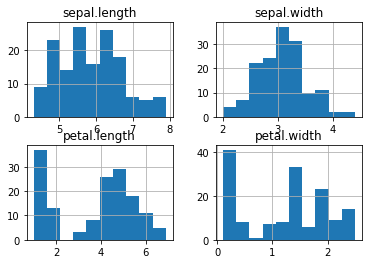

In [85]:
print("Original variables:")
_ = df.set_index('variety').hist()

Scaled variables:


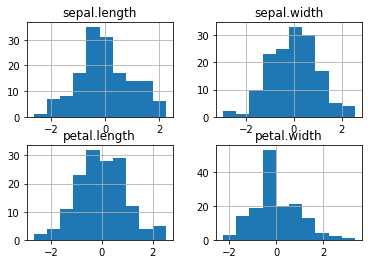

In [86]:
print("Scaled variables:")
_ = df_scaled.hist()